In [1]:
import pandas as pd
import numpy as np
from utils.cleaning_utils import canonical_url, clean_email, process_phone, clean_text, unique_list, clean_name, clean_streets, rem_words
from tqdm.auto import tqdm

In [2]:
df = pd.read_excel("/workspace/Manual_Verification_Dedup_POIs_Final.xlsx",sheet_name="duplicates_0.9_final_sample")

In [3]:
df.shape

(2000, 34)

# cleaning

In [4]:
df["latitude1"] = df["latitude1"].astype(np.float32)
df["longitude1"] = df["longitude1"].astype(np.float32)
df["latitude2"] = df["latitude2"].astype(np.float32)
df["longitude2"] = df["longitude2"].astype(np.float32)
df = df[~(df["longitude1"].isnull())]
df["officialName1"] = df["officialName1"].str.strip()
df["officialName1"] = df["officialName1"].replace("", np.nan)
df["officialName2"] = df["officialName2"].str.strip()
df["officialName2"] = df["officialName2"].replace("", np.nan)
df = df[~(df["officialName1"].isnull())]
df.drop_duplicates(inplace=True)

df["internet1"] = df["internet1"].apply(canonical_url)
df["email1"] = df["email1"].apply(canonical_url)
df["internet1"] = df["internet1"].apply(clean_email)
df["email1"] = df["email1"].apply(clean_email)
df["internet2"] = df["internet2"].apply(canonical_url)
df["email2"] = df["email2"].apply(canonical_url)
df["internet2"] = df["internet2"].apply(clean_email)
df["email2"] = df["email2"].apply(clean_email)
df["phoneNumbers1"] = df["phoneNumbers1"].apply(process_phone)
df["phoneNumbers2"] = df["phoneNumbers2"].apply(process_phone)

In [5]:
text_columns = [
    "officialName1", "brands1", "houseNumber1", "category1", "streets1",
    "cities1", "postalCode1", "subCategory1", "email1", "internet1",
    "officialName2", "brands2", "houseNumber2", "category2", "streets2",
    "cities2", "postalCode2", "subCategory2", "email2", "internet2"
]

for col in tqdm(text_columns):
    df[col] = df[col].astype("str").astype(str).replace('nan', np.nan)
    df[col] = df[col].apply(clean_text)

  0%|          | 0/20 [00:00<?, ?it/s]

In [6]:
df["brands1"] = df["brands1"].apply(unique_list)
df["subCategory1"] = df["subCategory1"].apply(unique_list)
df["officialName1"] = df["officialName1"].apply(unique_list)
df["streets1"] = df["streets1"].apply(unique_list)
df["cities1"] = df["cities1"].apply(unique_list)
df["brands2"] = df["brands2"].apply(unique_list)
df["subCategory2"] = df["subCategory2"].apply(unique_list)
df["officialName2"] = df["officialName2"].apply(unique_list)
df["streets2"] = df["streets2"].apply(unique_list)
df["cities2"] = df["cities2"].apply(unique_list)



In [7]:
df["subCategory1"].replace('unspecified', np.nan, regex=True, inplace=True)

df["cities1"] = df["cities1"].apply(clean_streets)
df["streets1"] = df["streets1"].apply(clean_streets)
df["officialName1"] = df["officialName1"].apply(clean_name)

df["officialName1"] = df["officialName1"].apply(rem_words)
df["cities1"] = df["cities1"].apply(rem_words)
df["streets1"] = df["streets1"].apply(rem_words)

df["subCategory2"].replace('unspecified', np.nan, regex=True, inplace=True)

df["cities2"] = df["cities2"].apply(clean_streets)
df["streets2"] = df["streets2"].apply(clean_streets)
df["officialName2"] = df["officialName2"].apply(clean_name)

df["officialName2"] = df["officialName2"].apply(rem_words)
df["cities2"] = df["cities2"].apply(rem_words)
df["streets2"] = df["streets2"].apply(rem_words)

In [8]:
df = df.replace(r'^\s*$', np.nan, regex=True)

df["officialName1"] = df["officialName1"].replace("", np.nan)
df = df[~(df["officialName1"].isnull())]
df["officialName2"] = df["officialName2"].replace("", np.nan)
df = df[~(df["officialName2"].isnull())]

In [9]:


df["category1"].replace('caf pub', 'cafe pub', regex=True,inplace=True)


df["category2"].replace('caf pub', 'cafe pub', regex=True,inplace=True)

In [10]:
df.to_csv("/workspace/Manual_Verification_Dedup_POIs_Final_cleaned.csv",index=None)

# create features

In [11]:
from utils.create_features import jaro, WRatio, ratio, davies, token_set_ratio, add_lat_lon_distance_features, strike_a_match, leven
from utils.features_utils import name_distance, extract_directions, is_direction_match, name_number_match,\
    is_related_cat, category_match, clean_email, sub_category_match, brand_match, house_match, email_url_match, phone_lcs,phone_category

In [12]:
# df["phoneNumbers1"] = df["phoneNumbers1"].apply(eval)
# df["phoneNumbers2"] = df["phoneNumbers2"].apply(eval)

In [13]:
df.rename(columns={'officialName1':'sourceNames1'},inplace=True)
df.rename(columns={'officialName2':'sourceNames2'},inplace=True)

In [14]:
similarity = name_distance(list(df["sourceNames1"]),list(df["sourceNames2"]))
df["similarity"] = similarity

  0%|          | 0/1 [00:00<?, ?it/s]

Batches:   0%|          | 0/4 [00:00<?, ?it/s]

In [15]:
df = add_lat_lon_distance_features(df)

In [16]:
df["direction1"] = df["sourceNames1"].apply(extract_directions)
df["direction2"] = df["sourceNames2"].apply(extract_directions)
df['Is_direction_match'] = df.apply(lambda x: is_direction_match(x.direction1, x.direction2), axis=1)


In [17]:
df["name1_number"] = df["sourceNames1"].str.extract('(\d+)')
df["name2_number"] = df["sourceNames2"].str.extract('(\d+)')
df['Is_name_number_match'] = df.apply(lambda x: name_number_match(x.name1_number, x.name2_number), axis=1)

In [18]:
df['Is_related_cat'] = df.apply(lambda x: is_related_cat(x.category1, x.category2), axis=1)
df['Is_category_match'] = df.apply(lambda x: category_match(x.category1, x.category2), axis=1)
df['Is_subcategory_match'] = df.apply(lambda x: sub_category_match(x.subCategory1, x.subCategory2), axis=1)

In [19]:
df['Is_brand_match'] = df.apply(lambda x: brand_match(x.brands1, x.brands2), axis=1)
df['Is_house_match'] = df.apply(lambda x: house_match(x.houseNumber1, x.houseNumber2), axis=1)
df['is_phone_match'] = df.apply(lambda x: phone_category(x.phoneNumbers1, x.phoneNumbers2), axis=1)

In [20]:
df['Is_email_match'] = df.apply(lambda x: email_url_match(x.email1, x.email2), axis=1)
df['Is_url_match'] = df.apply(lambda x: email_url_match(x.internet1, x.internet2), axis=1)


In [21]:
df['name_davies'] = df.apply(lambda x: davies(x.sourceNames1, x.sourceNames2), axis=1)
df['name_leven'] = df.apply(lambda x: leven(x.sourceNames1, x.sourceNames2), axis=1)
df['name_dice'] = df.apply(lambda x: strike_a_match(x.sourceNames1, x.sourceNames2), axis=1)
df['name_jaro'] = df.apply(lambda x: jaro(x.sourceNames1, x.sourceNames2), axis=1)
df['name_set_ratio'] = df.apply(lambda x: token_set_ratio(x.sourceNames1, x.sourceNames2), axis=1)

In [22]:
df['street_davies'] = df.apply(lambda x: davies(x.streets1, x.streets2), axis=1)
df['street_leven'] = df.apply(lambda x: leven(x.streets1, x.streets2), axis=1)
df['street_jaro'] = df.apply(lambda x: jaro(x.streets1, x.streets2), axis=1)

In [23]:
df['email_davies'] = df.apply(lambda x: davies(x.email1, x.email2), axis=1)
df['email_leven'] = df.apply(lambda x: leven(x.email1, x.email2), axis=1)
df['email_jaro'] = df.apply(lambda x: jaro(x.email1, x.email2), axis=1)

In [24]:
df['url_davies'] = df.apply(lambda x: davies(x.internet1, x.internet2), axis=1)
df['url_leven'] = df.apply(lambda x: leven(x.internet1, x.internet2), axis=1)
df['url_jaro'] = df.apply(lambda x: jaro(x.internet1, x.internet2), axis=1)

In [25]:
df['brands_davies'] = df.apply(lambda x: davies(x.brands1, x.brands2), axis=1)
df['brand_leven'] = df.apply(lambda x: leven(x.brands1, x.brands2), axis=1)
df['brand_jaro'] = df.apply(lambda x: jaro(x.brands1, x.brands2), axis=1)

In [26]:
df['phone_lcs'] = df.apply(lambda x: phone_lcs(x.phoneNumbers1, x.phoneNumbers2), axis=1)
df['subcat_WRatio'] = df.apply(lambda x: WRatio(x.subCategory1, x.subCategory2), axis=1)
df['subcat_ratio'] = df.apply(lambda x: ratio(x.subCategory1, x.subCategory2), axis=1)
df['subcat_token_set_ratio'] = df.apply(lambda x: token_set_ratio(x.subCategory1, x.subCategory2), axis=1)

In [27]:
cat_columns = [
    'Is_direction_match', 'Is_house_match', 'Is_category_match',
    'Is_subcategory_match', 'Is_brand_match', 'Is_related_cat',
    'Is_name_number_match', 'is_phone_match', 'Is_email_match', 'Is_url_match'
]


In [28]:
df = pd.get_dummies(df, columns = cat_columns)

In [29]:
cols = [
    'country', 'placeId1', 'placeId2', 'sourceNames1', 'sourceNames2',
    'category1', 'category2', 'brands1', 'brands2', 'email1', 'email2',
    'latitude1', 'longitude1', 'latitude2', 'longitude2', 'houseNumber1',
    'houseNumber2', 'streets1', 'streets2', 'cities1', 'cities2',
    'subCategory1', 'subCategory2', 'phoneNumbers1', 'phoneNumbers2',
    'internet1', 'internet2', 'postalCode1', 'postalCode2', 'similarity',
    'haversine', 'name_davies', 'name_leven', 'name_dice', 'name_jaro',
    'name_set_ratio', 'street_davies', 'street_leven', 'street_jaro',
    'email_davies', 'email_leven', 'email_jaro', 'url_davies', 'url_leven',
    'url_jaro', 'brands_davies', 'brand_leven', 'brand_jaro', 'phone_lcs',
    'subcat_WRatio', 'subcat_ratio', 'subcat_token_set_ratio',
    'Is_direction_match_0', 'Is_direction_match_1', 'Is_direction_match_2',
    'Is_house_match_0', 'Is_house_match_1', 'Is_house_match_2',
    'Is_category_match_0', 'Is_category_match_1', 'Is_subcategory_match_0',
    'Is_subcategory_match_1', 'Is_subcategory_match_2', 'Is_brand_match_0',
    'Is_brand_match_1', 'Is_brand_match_2', 'Is_brand_match_3',
    'Is_related_cat_0', 'Is_related_cat_1', 'Is_name_number_match_0',
    'Is_name_number_match_1', 'Is_name_number_match_2',
    'Is_name_number_match_3', 'is_phone_match_1', 'is_phone_match_2',
    'is_phone_match_3', 'is_phone_match_4', 'Is_email_match_0',
    'Is_email_match_1', 'Is_email_match_2', 'Is_url_match_0', 'Is_url_match_1',
    'Is_url_match_2','Duplicate(Y/N)'
]


In [30]:
missing_cols = set(cols) - set( df.columns )
# Add a missing column in test set with default value equal to 0


In [31]:
for c in missing_cols:
    df[c] = 0

In [32]:
df[cols].to_csv("/workspace/Manual_Verification_Dedup_POIs_Final_cleaned_features.csv",index=None)

# inference

In [33]:
import pandas as pd
import numpy as np
from utils.forest_infer import pred_multi
from utils.metrics import print_metrics
import glob
from tqdm import tqdm
from utils.forest_infer import pred_multi
from xgboost import XGBClassifier
import gc
from catboost import CatBoostClassifier

In [34]:
features = ['similarity', 'haversine', 'name_davies',
       'name_leven', 'name_dice', 'name_jaro', 'name_set_ratio',
       'street_davies', 'street_leven', 'street_jaro', 'email_davies',
       'email_leven', 'email_jaro', 'url_davies', 'url_leven', 'url_jaro',
       'brands_davies', 'brand_leven', 'brand_jaro', 'phone_lcs',
       'subcat_WRatio', 'subcat_ratio', 'subcat_token_set_ratio',
       'Is_direction_match_0', 'Is_direction_match_1', 'Is_direction_match_2',
       'Is_house_match_0', 'Is_house_match_1', 'Is_house_match_2',
       'Is_category_match_0', 'Is_category_match_1', 'Is_subcategory_match_0',
       'Is_subcategory_match_1', 'Is_subcategory_match_2', 'Is_brand_match_0',
       'Is_brand_match_1', 'Is_brand_match_2', 'Is_brand_match_3',
       'Is_related_cat_0', 'Is_related_cat_1', 'Is_name_number_match_0',
       'Is_name_number_match_1', 'Is_name_number_match_2',
       'Is_name_number_match_3', 'is_phone_match_1', 'is_phone_match_2',
       'is_phone_match_3', 'is_phone_match_4', 'Is_email_match_0',
       'Is_email_match_1', 'Is_email_match_2', 'Is_url_match_0',
       'Is_url_match_1', 'Is_url_match_2']

In [35]:
models = glob.glob(f"/workspace/models/model_duplicate_gsplit_lgb*")

In [36]:
all_pred = []
for model_file in tqdm(models):
    prediction = pred_multi(model_file,df[features])
    all_pred.append(prediction)
    
all_pred = np.array(all_pred)
pred = np.mean(all_pred, axis=0)
df["prediction_lgb_probab"] = pred
df["prediction_lgb"] = pred>0.5
df["prediction_lgb"] = df["prediction_lgb"]*1

  0%|          | 0/5 [00:00<?, ?it/s]

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
[W] [07:50:05.033953] Treelite currently does not support float64 model parameters. Accuracy may degrade slightly relative to native LightGBM invocation.


  0%|          | 0/4 [00:00<?, ?it/s]

 20%|██        | 1/5 [00:12<00:50, 12.57s/it]

[W] [07:50:06.051769] Treelite currently does not support float64 model parameters. Accuracy may degrade slightly relative to native LightGBM invocation.


  0%|          | 0/4 [00:00<?, ?it/s]

 40%|████      | 2/5 [00:13<00:17,  5.77s/it]

[W] [07:50:07.056651] Treelite currently does not support float64 model parameters. Accuracy may degrade slightly relative to native LightGBM invocation.


  0%|          | 0/4 [00:00<?, ?it/s]

 60%|██████    | 3/5 [00:14<00:07,  3.61s/it]

[W] [07:50:08.108200] Treelite currently does not support float64 model parameters. Accuracy may degrade slightly relative to native LightGBM invocation.


  0%|          | 0/4 [00:00<?, ?it/s]

 80%|████████  | 4/5 [00:15<00:02,  2.56s/it]

[W] [07:50:09.062109] Treelite currently does not support float64 model parameters. Accuracy may degrade slightly relative to native LightGBM invocation.


  0%|          | 0/4 [00:00<?, ?it/s]

100%|██████████| 5/5 [00:16<00:00,  3.34s/it]


In [37]:
df.columns

Index(['country', 'placeId1', 'placeId2', 'distance in meters', 'sourceNames1',
       'sourceNames2', 'category1', 'category2', 'brands1', 'brands2',
       'email1', 'email2', 'latitude1', 'longitude1', 'latitude2',
       'longitude2', 'houseNumber1', 'houseNumber2', 'streets1', 'streets2',
       'cities1', 'cities2', 'subCategory1', 'subCategory2', 'phoneNumbers1',
       'phoneNumbers2', 'internet1', 'internet2', 'postalCode1', 'postalCode2',
       'Duplicate(Y/N)', 'POI_OOB(Y/N)', 'Remark', 'Allocation', 'similarity',
       'haversine', 'direction1', 'direction2', 'name1_number', 'name2_number',
       'name_davies', 'name_leven', 'name_dice', 'name_jaro', 'name_set_ratio',
       'street_davies', 'street_leven', 'street_jaro', 'email_davies',
       'email_leven', 'email_jaro', 'url_davies', 'url_leven', 'url_jaro',
       'brands_davies', 'brand_leven', 'brand_jaro', 'phone_lcs',
       'subcat_WRatio', 'subcat_ratio', 'subcat_token_set_ratio',
       'Is_direction_match_1',

In [38]:
# fig_conf= print_metrics(df["Duplicate(Y/N)"],df["prediction_lgb"])

In [39]:
models = glob.glob(f"/workspace/models/xgboost_dedup_v2_*")

In [40]:
def pred_multi_xgb(model_file,df):
    xgb_model = XGBClassifier()
    xgb_model.load_model(model_file)
    prediction = xgb_model.predict_proba(df)[:, 1]
    del xgb_model
    gc.collect()
    return prediction

In [41]:
all_pred = []
for model_file in tqdm(models):
    prediction = pred_multi_xgb(model_file,df[features])
    all_pred.append(prediction)
    
all_pred = np.array(all_pred)
pred = np.mean(all_pred, axis=0)
df["prediction_xgb_probab"] = pred
df["prediction_xgb"] = pred>0.5
df["prediction_xgb"] = df["prediction_xgb"]*1

100%|██████████| 5/5 [00:03<00:00,  1.49it/s]


In [42]:
# fig_conf= print_metrics(df["Duplicate(Y/N)"],df["prediction_xgb"])

In [43]:
models = glob.glob(f"/workspace/models/catboost_dedup_*")

In [44]:
def pred_multi_catboost(model_file,df):
    xgb_model = CatBoostClassifier()
    xgb_model.load_model(model_file)
    prediction = xgb_model.predict_proba(df)[:, 1]
    del xgb_model
    gc.collect()
    return prediction

In [45]:
all_pred = []
for model_file in tqdm(models):
    prediction = pred_multi_catboost(model_file,df[features])
    all_pred.append(prediction)
    
all_pred = np.array(all_pred)
pred = np.mean(all_pred, axis=0)
df["prediction_catboost_probab"] = pred
df["prediction_catboost"] = pred>0.5
df["prediction_catboost"] = df["prediction_catboost"]*1

100%|██████████| 5/5 [00:02<00:00,  2.09it/s]


0.5057028427147272


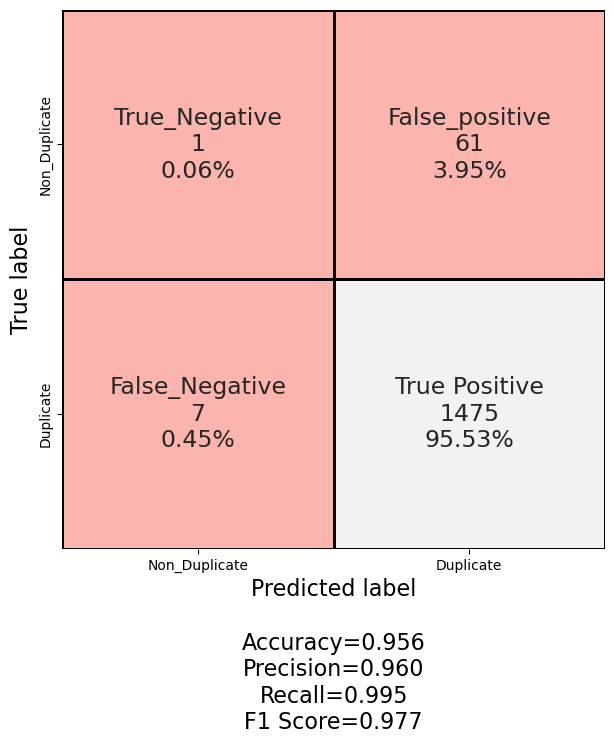

In [ ]:
# fig_conf= print_metrics(df["Duplicate(Y/N)"],df["prediction_catboost"])

In [95]:
df.to_csv("/workspace/Manual_Verification_Dedup_POIs_Final1.csv",index=None)